In [62]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Imports**

In [63]:
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
import os
import torch.nn as nn
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import time
import copy
import random


**Σημείωση: Σε ορισμένες περιπτώσεις χρησιμοποιείται μικρότερο learning rate διότι οταν χρησιμοποιούνταν το συνιστώμενο τότε το αποτέλεσμα ήταν nan**

# Ερώτημα 1 : Feedforward Neural Network

# Βήμα 1 : Φόρτωση δεδομένων (mfccs)

Στο βήμα αυτό δημιουργώ μια συνάρτηση που φορτώνει τα δεδομένα MFCC και στην συνέχεια αρχικοποιώ 3 Dataloaders αφού πρώτα προετοιμάζω τα δεδομένα μέσω των συναρτήσεων prepare_data, create_dataset, create_dataloader.

In [64]:
device = "cpu"

def get_label_id(label):
    switch = {
        "hiphop": 0,
        "blues": 1,
        "classical": 2,
        "rock_metal_hardrock": 3
    }
    return switch.get(label, None)

def label_conversion(labels):
    converted_labels = []
    for label in labels:
        label_id = get_label_id(label)
        if label_id is not None:
            converted_labels.append(label_id)
    return converted_labels

In [65]:
def load_data(path):
    return np.load(path)

def prepare_data(data, labels):
    labels_tensor = torch.tensor(label_conversion(labels), dtype=torch.long)
    data_tensor = torch.tensor(data, dtype=torch.float32)
    return data_tensor, labels_tensor

def create_dataset(data_tensor, labels_tensor):
    return TensorDataset(data_tensor, labels_tensor)

def create_dataloader(dataset, batch_size, shuffle):
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

# Load training data
mfcc_train = load_data('/content/drive/MyDrive/ML/music_genre_data_di/train/mfccs/X.npy')
labels_train = load_data('/content/drive/MyDrive/ML/music_genre_data_di/train/mfccs/labels.npy')
train_data, train_labels = prepare_data(mfcc_train, labels_train)

# Load testing data
mfcc_test = load_data('/content/drive/MyDrive/ML/music_genre_data_di/test/mfccs/X.npy')
labels_test = load_data('/content/drive/MyDrive/ML/music_genre_data_di/test/mfccs/labels.npy')
test_data, test_labels = prepare_data(mfcc_test, labels_test)

# Load validation data
mfcc_val = load_data('/content/drive/MyDrive/ML/music_genre_data_di/val/mfccs/X.npy')
labels_valid = load_data('/content/drive/MyDrive/ML/music_genre_data_di/val/mfccs/labels.npy')
valid_data, valid_labels = prepare_data(mfcc_val, labels_valid)

# Create datasets
train_dataset = create_dataset(train_data, train_labels)
test_dataset = create_dataset(test_data, test_labels)
val_dataset = create_dataset(valid_data, valid_labels)

# Create DataLoader objects
train_loader = create_dataloader(train_dataset, batch_size=16, shuffle=True)
test_loader = create_dataloader(test_dataset, batch_size=16, shuffle=False)
val_loader = create_dataloader(val_dataset, batch_size=16, shuffle=True)


# Βήμα 2 : Ορισμός Νευρωνικού Δικτύου

Στο ερώτημα αυτό γινεται ουσιασιαστικά η αρχικοποίηση ενός νευρωνικού δικτύου, χωρίς να γίνει χρήση κάποιας συνάρτησης ενεργοποίησης.

In [66]:
class FullyConnectedNetwork(nn.Module):
    def __init__(self):
        super(FullyConnectedNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.layer1 = nn.Linear(26, 128)
        self.layer2 = nn.Linear(128, 32)
        self.layer3 = nn.Linear(32, 4)

    def forward(self, x):
        x = self.flatten(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        return x

# Βήμα 3: Ορισμός διαδικασίας εκπαίδευσης

Παρακάτω κάνω την εκπαίδευση του μοντέλου . Συγκεκριμένα σύμφωνα με τον αριθμό των epochs που δίνεται στην εκφώνηση, δηλαδή το πέρασμα των δεδομένων εκπαίδευσης μέσω του αλγόριθμου ακολουθείται η παρακάτω διαδικασία: <br>

Αρχικά φορτώνω χρησιμοποιώντας τον dataloader, batch δεδομένων. Το batch αυτό διαθέτει ορισμένες τιμές τις οποίες όπου φορτώνω το νευρωνικό δίκτυο μαυτές. Στην συνέχεια για την τιμή που εξετάζεται εκείνη την στιγμή υπολογίζω το loss. Έπειτα σύμφωνα με τις παραμέτρους της loss.backward βρίσκω τα gradient για το loss. Μέσω της χρήσης του optimizer βελτιώνει την ακρίβεια των αποτελεσμάτων του νευρωνικού δικτύου.  





In [67]:
def train_network(epochs, optimizer, dataloader, loss_fn, model):
    for epoch in range(epochs):
        size = len(dataloader.dataset)
        for batch, (X, y) in enumerate(dataloader):
            if device == 'cuda':
              X = X.to(device)
              y = y.to(device)

            else :
              X=X
              Y=y

            # Compute prediction and loss
            pred = model(X)
            loss = loss_fn(pred, y)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss, current = loss.item(), batch * len(X)
            print(f"Epoch: {epoch+1}, Loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    return model

# Βήμα 4: Ορισμός διαδικασίας αξιολόγησης

Στο βήμα αυτό δημιουργώ μια συνάρτηση προκειμένου να γινει η διαδικασία της αξιολόγησης. Συγκεκριμένα προσπελαύνει τις παρτίδες ενός Data Loader. Αυτό γίνεται με όμοιο τρόπο όπως και παραπάνω στο βήμα εκπαίδευσης.  Αυτό που προστίθεται είναι ότι κάνω πρόβλεψη κια παο αυτήν προκύπτει ένα αποτέλεσμα το οποίο είναι η έξοδος απ οτο νευρωνικό δίκτυο. Απο αυτην γίνεται ο υπολογισμός της απώλειας όπως επίσης και του f1 , ακρίβειας και του confusion matrix.

In [68]:
def calculate_metrics(true_labels, predictions):
    conf_matrix = confusion_matrix(true_labels, predictions)
    f1 = f1_score(true_labels, predictions, average='macro')
    return conf_matrix, f1



def evaluate(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    evaluation_loss = 0
    accuracy = 0
    pred_y = []
    test_y = []


    # the no_grad command tells PyTorch that we dont want to accumulate gradients for these operations
    with torch.no_grad():
        for X, y in dataloader:

            if device == 'cuda':
              X = X.to(device)
              y = y.to(device)

            else :
              X=X
              Y=y


            pred = model(X)
            # X = X.type(torch.FloatTensor)
            # pred_y.append(pred.argmax(1))
            # Store predictions and true labels
            pred_y.extend(pred.argmax(1).cpu().numpy())  # Convert to numpy and store
            test_y.extend(y.cpu().numpy())  # Convert to numpy and store
            evaluation_loss += loss_fn(pred, y).item()
            accuracy += (pred.argmax(1) == y).type(torch.float).sum().item()
            # test_y.append(y)


    evaluation_loss /= size
    accuracy /= size
    # test_y = torch.cat(test_y)
    # pred_y = torch.cat(pred_y)

    conf, f1 = calculate_metrics(test_y, pred_y)

    # print(f"Test Error: \n Accuracy: {(100*accuracy):>0.1f}%, Avg loss: {evaluation_loss:>8f} \n")
    return evaluation_loss, accuracy, f1, conf

# Βήμα 5: Εκπαίδευση δικτύου

Σύμφωνα με τις οδηγίες της εκφώνησης.

In [72]:
# Define the model
the_mod = FullyConnectedNetwork().to(device)

# Move the model to the device
the_mod = the_mod.to(device)

# Define the loss function
the_loss = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = torch.optim.Adam(the_mod.parameters(), lr=0.002)


time_begin = time.time()
# Train the model
the_mod = train_network(30, optimizer, train_loader, the_loss, the_mod)

# Evaluate the model
evaluation_loss, accuracy, f1, conf = evaluate(test_loader, the_mod, the_loss)

# Calculate the elapsed time
elapsed_time = time.time() - time_begin

# Display the results
print(f"Elapsed Time: {elapsed_time} sec\n"
      f"Test Error: \n"
      f" Accuracy: {accuracy * 100:.1f}%, Avg loss: {evaluation_loss:.6f}, "
      f"macro F1 score: {f1 * 100:.1f}%, \n"
      f"confusion matrix: \n{conf} \n")


Η έξοδος ροής περικόπηκε στις τελευταίες 5000 γραμμές.
Epoch: 6, Loss: 1.022806  [  144/ 3200]
Epoch: 6, Loss: 0.668777  [  160/ 3200]
Epoch: 6, Loss: 0.602015  [  176/ 3200]
Epoch: 6, Loss: 1.136499  [  192/ 3200]
Epoch: 6, Loss: 0.902462  [  208/ 3200]
Epoch: 6, Loss: 0.718442  [  224/ 3200]
Epoch: 6, Loss: 0.823543  [  240/ 3200]
Epoch: 6, Loss: 0.719557  [  256/ 3200]
Epoch: 6, Loss: 0.799502  [  272/ 3200]
Epoch: 6, Loss: 0.505491  [  288/ 3200]
Epoch: 6, Loss: 0.829117  [  304/ 3200]
Epoch: 6, Loss: 0.614080  [  320/ 3200]
Epoch: 6, Loss: 0.911260  [  336/ 3200]
Epoch: 6, Loss: 0.751196  [  352/ 3200]
Epoch: 6, Loss: 0.859443  [  368/ 3200]
Epoch: 6, Loss: 0.913295  [  384/ 3200]
Epoch: 6, Loss: 0.692659  [  400/ 3200]
Epoch: 6, Loss: 0.442791  [  416/ 3200]
Epoch: 6, Loss: 0.594685  [  432/ 3200]
Epoch: 6, Loss: 0.537810  [  448/ 3200]
Epoch: 6, Loss: 0.886418  [  464/ 3200]
Epoch: 6, Loss: 0.988472  [  480/ 3200]
Epoch: 6, Loss: 0.855667  [  496/ 3200]
Epoch: 6, Loss: 0.710637 

# Βήμα 6: Εκπαίδευση δικτύου με GPU

In [73]:
if torch.cuda.is_available():
  device="cuda"
else:
    device="cpu"


# Define the model
the_mod = FullyConnectedNetwork().to(device)

# Move the model to the device
the_mod = the_mod.to(device)

# Define the loss function
the_loss = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = torch.optim.Adam(the_mod.parameters(), lr=0.002)


time_begin = time.time()
# Train the model
the_mod = train_network(30, optimizer, train_loader, the_loss, the_mod)

# Evaluate the model
evaluation_loss, accuracy, f1, conf = evaluate(test_loader, the_mod, the_loss)

# Calculate the elapsed time
elapsed_time = time.time() - time_begin

# Display the results
print(f"Elapsed Time: {elapsed_time} sec\n"
      f"Test Error: \n"
      f" Accuracy: {accuracy * 100:.1f}%, Avg loss: {evaluation_loss:.6f}, "
      f"macro F1 score: {f1 * 100:.1f}%, \n"
      f"confusion matrix: \n{conf} \n")

Η έξοδος ροής περικόπηκε στις τελευταίες 5000 γραμμές.
Epoch: 6, Loss: 0.643124  [  144/ 3200]
Epoch: 6, Loss: 0.674598  [  160/ 3200]
Epoch: 6, Loss: 1.281536  [  176/ 3200]
Epoch: 6, Loss: 1.085570  [  192/ 3200]
Epoch: 6, Loss: 0.483759  [  208/ 3200]
Epoch: 6, Loss: 0.838921  [  224/ 3200]
Epoch: 6, Loss: 0.906507  [  240/ 3200]
Epoch: 6, Loss: 0.984860  [  256/ 3200]
Epoch: 6, Loss: 0.587396  [  272/ 3200]
Epoch: 6, Loss: 1.050049  [  288/ 3200]
Epoch: 6, Loss: 1.218599  [  304/ 3200]
Epoch: 6, Loss: 0.907213  [  320/ 3200]
Epoch: 6, Loss: 0.939731  [  336/ 3200]
Epoch: 6, Loss: 0.725873  [  352/ 3200]
Epoch: 6, Loss: 1.081347  [  368/ 3200]
Epoch: 6, Loss: 0.798200  [  384/ 3200]
Epoch: 6, Loss: 0.675511  [  400/ 3200]
Epoch: 6, Loss: 0.807930  [  416/ 3200]
Epoch: 6, Loss: 0.605646  [  432/ 3200]
Epoch: 6, Loss: 0.727531  [  448/ 3200]
Epoch: 6, Loss: 0.887455  [  464/ 3200]
Epoch: 6, Loss: 0.816044  [  480/ 3200]
Epoch: 6, Loss: 0.571602  [  496/ 3200]
Epoch: 6, Loss: 0.947130 

In [ ]:
Προκύπτει ότι με τη χρήση cuda αντί για την cpu η εκτέλεση ήταν γρηγορότερη.

# Βήμα 7: Επιλογή μοντέλου

In [76]:
device = 'cpu'

def train_network(epochs, optimizer, train_dataloader, val_dataloader, loss_fn, model):
    best_model = None
    best_f1 = 0.0

    for epoch in range(epochs):
        size = len(train_dataloader.dataset)
        for batch, (X, y) in enumerate(train_dataloader):
            if device == 'cuda':
              X = X.to(device)
              y = y.to(device)

            else :
              X=X
              Y=y

            # Compute prediction and loss
            pred = model(X)
            loss = loss_fn(pred, y)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss, current = loss.item(), batch * len(X)
            print(f"Epoch: {epoch+1}, Loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

        # Validation phase
        with torch.no_grad():
            val_preds, val_labels = [], []
            for X_val, y_val in val_dataloader:
                X_val = X_val.to(device)
                y_val = y_val.to(device)
                pred_val = model(X_val)
                val_preds.extend(pred_val.argmax(dim=1).cpu().numpy())
                val_labels.extend(y_val.cpu().numpy())

            f1 = f1_score(val_labels, val_preds, average='macro')
            print(f"Epoch: {epoch+1}, Validation F1: {f1:.4f}")

            if f1 > best_f1:
                best_f1 = f1
                best_model = copy.deepcopy(model)

    return best_model


# Define the model
the_mod = FullyConnectedNetwork().to(device)

# Move the model to the device
the_mod = the_mod.to(device)

# Define the loss function
the_loss = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = torch.optim.Adam(the_mod.parameters(), lr=0.002)

time_begin = time.time()
# Train the model
the_mod = train_network(30, optimizer, train_loader, val_loader ,the_loss, the_mod)

# Evaluate the model
evaluation_loss, accuracy, f1, conf = evaluate(test_loader, the_mod, the_loss)

# Calculate the elapsed time
elapsed_time = time.time() - time_begin

# Display the results
print(f"Elapsed Time: {elapsed_time} sec\n"
      f"Test Error: \n"
      f" Accuracy: {accuracy * 100:.1f}%, Avg loss: {evaluation_loss:.6f}, "
      f"macro F1 score: {f1 * 100:.1f}%, \n"
      f"confusion matrix: \n{conf} \n")


Η έξοδος ροής περικόπηκε στις τελευταίες 5000 γραμμές.
Epoch: 6, Loss: 0.582286  [  544/ 3200]
Epoch: 6, Loss: 0.756985  [  560/ 3200]
Epoch: 6, Loss: 0.713046  [  576/ 3200]
Epoch: 6, Loss: 0.850165  [  592/ 3200]
Epoch: 6, Loss: 0.998627  [  608/ 3200]
Epoch: 6, Loss: 0.527149  [  624/ 3200]
Epoch: 6, Loss: 0.596767  [  640/ 3200]
Epoch: 6, Loss: 0.492335  [  656/ 3200]
Epoch: 6, Loss: 0.848991  [  672/ 3200]
Epoch: 6, Loss: 0.955966  [  688/ 3200]
Epoch: 6, Loss: 0.807339  [  704/ 3200]
Epoch: 6, Loss: 0.920126  [  720/ 3200]
Epoch: 6, Loss: 0.674242  [  736/ 3200]
Epoch: 6, Loss: 1.086036  [  752/ 3200]
Epoch: 6, Loss: 0.777668  [  768/ 3200]
Epoch: 6, Loss: 0.847299  [  784/ 3200]
Epoch: 6, Loss: 0.909526  [  800/ 3200]
Epoch: 6, Loss: 0.880414  [  816/ 3200]
Epoch: 6, Loss: 0.585622  [  832/ 3200]
Epoch: 6, Loss: 0.912619  [  848/ 3200]
Epoch: 6, Loss: 1.068725  [  864/ 3200]
Epoch: 6, Loss: 0.721871  [  880/ 3200]
Epoch: 6, Loss: 0.580616  [  896/ 3200]
Epoch: 6, Loss: 0.834804 

# Ερώτημα 2: Convolutional Neural Network

# Βήμα 1: Φόρτωση δεδομένων (spectrograms)

Προφανώς η διαδικασία που ακολουθεί είναι ίδια με την παραπάνω ωστόσο ο φάκελος απο τον οποίο παίρνουμε δεδομένα αλλάζει διότι στο σημείο αυτό φορτώνουε απο τον φάκελο melgrams επίσης σχεδιάζουμε απο κάθε set το γράφημα του .

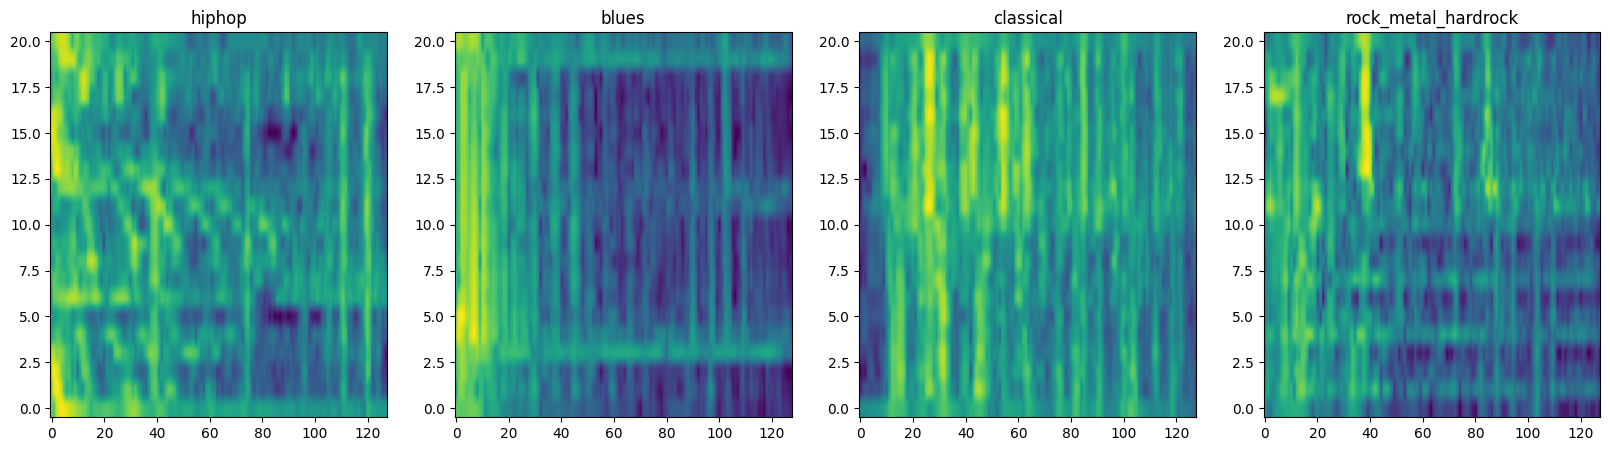

In [200]:
def load_data(path):
    return np.load(path)

def prepare_data(data, labels):
    labels_tensor = torch.tensor(label_conversion(labels), dtype=torch.long)
    data_tensor = torch.tensor(data, dtype=torch.float32)
    return data_tensor, labels_tensor

def create_dataset(data_tensor, labels_tensor):
    return TensorDataset(data_tensor, labels_tensor)

def create_dataloader(dataset, batch_size, shuffle):
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

# Load training data
mfcc_train = load_data('/content/drive/MyDrive/ML/music_genre_data_di/train/melgrams/X.npy')
labels_train = load_data('/content/drive/MyDrive/ML/music_genre_data_di/train/melgrams/labels.npy')
train_data, train_labels = prepare_data(mfcc_train, labels_train)

# Load testing data
mfcc_test = load_data('/content/drive/MyDrive/ML/music_genre_data_di/test/melgrams/X.npy')
labels_test = load_data('/content/drive/MyDrive/ML/music_genre_data_di/test/melgrams/labels.npy')
test_data, test_labels = prepare_data(mfcc_test, labels_test)

# Load validation data
mfcc_val = load_data('/content/drive/MyDrive/ML/music_genre_data_di/val/melgrams/X.npy')
labels_valid = load_data('/content/drive/MyDrive/ML/music_genre_data_di/val/melgrams/labels.npy')
valid_data, valid_labels = prepare_data(mfcc_val, labels_valid)

# Create datasets
train_dataset = create_dataset(train_data, train_labels)
test_dataset = create_dataset(test_data, test_labels)
val_dataset = create_dataset(valid_data, valid_labels)

# Create DataLoader objects
train_loader = create_dataloader(train_dataset, batch_size=16, shuffle=True)
test_loader = create_dataloader(test_dataset, batch_size=16, shuffle=False)
val_loader = create_dataloader(val_dataset, batch_size=16, shuffle=True)


# Function to extract a sample from each class
def get_samples_by_class(data, labels, num_classes=4):
    samples = []
    for i in range(num_classes):
        idx = (labels == i).nonzero(as_tuple=True)[0][0]
        samples.append(data[idx].numpy())
    return samples

# Get one sample from each class
samples = get_samples_by_class(train_data, train_labels)

# Plot the samples
genres = ["hiphop", "blues", "classical", "rock_metal_hardrock"]

fig, axes = plt.subplots(1, 4, figsize=(20, 5))
for i, sample in enumerate(samples):
    axes[i].imshow(sample, aspect='auto', origin='lower')
    axes[i].set_title(genres[i])
plt.show()

# Βήμα 2: Ορισμός Νευρωνικού Δικτύου

In [202]:
class Convolutional_Neural_Network_Simple(nn.Module):
  def __init__(self, out_dim):
    super().__init__()
    # in channels, out_channels, kernel_size
    self.conv1 = nn.Conv2d(1, 16, 5)
    self.conv2 = nn.Conv2d(16, 32, 5)
    self.conv3 = nn.Conv2d(32, 64, 5)
    self.conv4 = nn.Conv2d(64, 128, 5)

    self.lin_s = nn.Sequential(
            nn.Linear(71680, 1024),
            nn.Linear(1024, 256),
            nn.Linear(256, 32),
            nn.Linear(32, 4),
        )

  def conv_layers(self, x):
        x = torch.unsqueeze(x, 1)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        return x

  def linear_layers(self, x):
        siz = x.size(0)
        x = x.view(siz, -1)
        x = self.lin_s(x)
        return x

  def forward(self, x):
        x = self.conv_layers(x)
        x = self.linear_layers(x)
        return x



# Βήμα 3: Εκπαίδευση δικτύου

In [98]:
device = 'cpu'


def train_loop(num_epochs, dataloader, val_dataloader, model, loss_fn, optimizer, device, show=False):
    size = len(dataloader.dataset)

    # Initialize the best model
    best_model = model
    best_score = 0.0

    for epoch in range(num_epochs):
        if show:
            print(f"Epoch {epoch+1}\n-------------------------------")

        model.train()
        for batch, (X, y) in enumerate(dataloader):
            if device == 'cuda':
              X = X.to(device)
              y = y.to(device)

            else :
              X=X
              Y=y
            # Ensure X is a FloatTensor and normalize if necessary
            # X = X.type(torch.FloatTensor).to(device)
            # Normalize X if not already done. Example: X = (X - X.mean()) / X.std()

            # Compute prediction and loss
            pred = model(X)
            loss = loss_fn(pred, y)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            # Apply gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
            optimizer.step()

            if show and batch % 10 == 0:
                loss_value = loss.item()
                current = batch * len(X)
                print(f"loss: {loss_value:>7f}  [{current:>5d}/{size:>5d}]")

        # Validation
        model.eval()
        with torch.no_grad():
            val_loss, accuracy, f1, conf = evaluate(val_dataloader, model, loss_fn)

        if show:
            print(f"Validation F1: {f1:.4f}, Validation Loss: {val_loss:.4f}")

        # Save the best model
        if f1 > best_score:
            best_score = f1
            torch.save(model.state_dict(), 'best_model.pth')

    if show:
        print("Done!")

    # Load the best model
    best_model.load_state_dict(torch.load('best_model.pth'))
    return best_model


the_mod = Convolutional_Neural_Network_Simple(4).to(device)  ##assing model to device

# define the loss function
the_loss = nn.CrossEntropyLoss()

# define the optimizer object
optimizer = torch.optim.Adam(the_mod.parameters(), lr=0.002)

time_begin = time.time()

# define number of epochs
best_model = train_loop(1,train_loader, val_loader, the_mod, the_loss, optimizer, 'cpu', show=True)
evaluation_loss, accuracy, f1, conf = evaluate(test_loader, best_model, the_loss)

# Calculate the elapsed time
elapsed_time = time.time() - time_begin

# Display the results
print(f"Elapsed Time: {elapsed_time} sec\n"
      f"Test Error: \n"
      f" Accuracy: {accuracy * 100:.1f}%, Avg loss: {evaluation_loss:.6f}, "
      f"macro F1 score: {f1 * 100:.1f}%, \n"
      f"confusion matrix: \n{conf} \n")

Epoch 1
-------------------------------
loss: 1.382679  [    0/ 3200]
loss: 156178.234375  [  160/ 3200]
loss: 52572.769531  [  320/ 3200]
loss: 250.145309  [  480/ 3200]
loss: 279.992249  [  640/ 3200]
loss: 86.051170  [  800/ 3200]
loss: 180.921356  [  960/ 3200]
loss: 77.557449  [ 1120/ 3200]
loss: 122.465111  [ 1280/ 3200]
loss: 31.193466  [ 1440/ 3200]
loss: 19.008533  [ 1600/ 3200]
loss: 25.372232  [ 1760/ 3200]
loss: 37.700443  [ 1920/ 3200]
loss: 12.513417  [ 2080/ 3200]
loss: 7.673689  [ 2240/ 3200]
loss: 4.588744  [ 2400/ 3200]
loss: 13.051048  [ 2560/ 3200]
loss: 172.891098  [ 2720/ 3200]
loss: 122.963341  [ 2880/ 3200]
loss: 16.945219  [ 3040/ 3200]
Validation F1: 0.2734, Validation Loss: 0.6761
Done!
Elapsed Time: 450.65730810165405 sec
Test Error: 
 Accuracy: 28.3%, Avg loss: 0.727144, macro F1 score: 25.7%, 
confusion matrix: 
[[148  65 106  37]
 [126  66 114  18]
 [ 69  67 155   6]
 [165  75 139  20]] 



# GPU

In [95]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

the_mod = Convolutional_Neural_Network_Simple(4).to(device)  # Assign model to device

# Define the hyperparameters of the optimization/training process
the_loss = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(the_mod.parameters(), lr=0.002)

# Train the model
best_model = train_loop(1, train_loader, val_loader, the_mod, the_loss, optimizer, device, show=True)

# Evaluate the model
evaluation_loss, accuracy, f1, conf = evaluate(test_loader, best_model, the_loss)

print(f"Test Error: \n"
      f" Accuracy: {accuracy * 100:.1f}%, Avg loss: {evaluation_loss:.6f}, "
      f"macro F1 score: {f1 * 100:.1f}%, \n"
      f"confusion matrix: \n{conf} \n")

Epoch 1
-------------------------------
loss: 1.356611  [    0/ 3200]
loss: 62315.601562  [  160/ 3200]
loss: 1114.454712  [  320/ 3200]
loss: 340.446716  [  480/ 3200]
loss: 829.835388  [  640/ 3200]
loss: 389.576355  [  800/ 3200]
loss: 55.880592  [  960/ 3200]
loss: 227.629807  [ 1120/ 3200]
loss: 64.795860  [ 1280/ 3200]
loss: 132.637527  [ 1440/ 3200]
loss: 36.896584  [ 1600/ 3200]
loss: 10.478741  [ 1760/ 3200]
loss: 43.752483  [ 1920/ 3200]
loss: 46.273567  [ 2080/ 3200]
loss: 79.304924  [ 2240/ 3200]
loss: 57.291031  [ 2400/ 3200]
loss: 19.090734  [ 2560/ 3200]
loss: 37.544380  [ 2720/ 3200]
loss: 5.218813  [ 2880/ 3200]
loss: 15.092675  [ 3040/ 3200]
Validation F1: 0.2234, Validation Loss: 1.1561
Done!
Test Error: 
 Accuracy: 25.8%, Avg loss: 1.231479, macro F1 score: 23.9%, 
confusion matrix: 
[[ 61  64 175  56]
 [ 50  69 140  65]
 [ 52  42 182  21]
 [ 76  76 204  43]] 



# Βήμα 4: Pooling and padding

In [169]:

class Convolutional_Neural_Network_Pad_Pool(nn.Module):
    def __init__(self, out_dim):
        super(Convolutional_Neural_Network_Pad_Pool, self).__init__()
       # in channels, out_channels, kernel_size
        self.max = nn.MaxPool2d(kernel_size=2)
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=5, padding=2)

        self.lin = nn.Sequential(
            nn.Linear(1024, 1024),
            nn.Linear(1024, 256),
            nn.Linear(256, 32),
            nn.Linear(32, 4),
        )

    def conv_layers(self, x):
          x = torch.unsqueeze(x, 1)
          x = self.max(self.conv1(x))
          x = self.max(self.conv2(x))
          x = self.max(self.conv3(x))
          x = self.max(self.conv4(x))
          return x

    def linear_layers(self, x):
          x = x.view(x.size(0), -1)
          x = self.lin(x)
          return x

    def forward(self, x):
          x = self.conv_layers(x)
          x = self.linear_layers(x)
          return x


In [171]:
device = 'cpu'

the_mod = Convolutional_Neural_Network_Pad_Pool(4).to(device)  ##assing model to device

# define the loss function
the_loss = nn.CrossEntropyLoss()

# define the optimizer object
optimizer = torch.optim.Adam(the_mod.parameters(), lr = 0.002)

# define number of epochs
best_model = train_loop(1,train_loader, val_loader, the_mod, the_loss, optimizer, 'cpu', show=True)
evaluation_loss, accuracy, f1, conf = evaluate(test_loader, best_model, the_loss)

print(f"Test Error: \n"
      f" Accuracy: {accuracy * 100:.1f}%, Avg loss: {evaluation_loss:.6f}, "
      f"macro F1 score: {f1 * 100:.1f}%, \n"
      f"confusion matrix: \n{conf} \n")



Epoch 1
-------------------------------
loss: 1.520563  [    0/ 3200]
loss: 107.832367  [  160/ 3200]
loss: 22.088081  [  320/ 3200]
loss: 9.636937  [  480/ 3200]
loss: 6.065878  [  640/ 3200]
loss: 3.772574  [  800/ 3200]
loss: 4.123641  [  960/ 3200]
loss: 3.588115  [ 1120/ 3200]
loss: 3.861722  [ 1280/ 3200]
loss: 0.700899  [ 1440/ 3200]
loss: 1.129523  [ 1600/ 3200]
loss: 1.162222  [ 1760/ 3200]
loss: 1.019998  [ 1920/ 3200]
loss: 1.126717  [ 2080/ 3200]
loss: 1.336264  [ 2240/ 3200]
loss: 1.361936  [ 2400/ 3200]
loss: 0.905227  [ 2560/ 3200]
loss: 1.166754  [ 2720/ 3200]
loss: 1.494378  [ 2880/ 3200]
loss: 1.854006  [ 3040/ 3200]
Validation F1: 0.3499, Validation Loss: 0.0799
Done!
Test Error: 
 Accuracy: 46.5%, Avg loss: 0.075259, macro F1 score: 40.5%, 
confusion matrix: 
[[336   0  14   6]
 [260   1  15  48]
 [ 14  24 213  46]
 [298   1  10  90]] 



# Βήμα 5: Activation functions

In [183]:

class Convolutional_Neural_Network_Act_Func(nn.Module):
    def __init__(self, out_dim):
        super(Convolutional_Neural_Network_Act_Func, self).__init__()
        self.max = nn.MaxPool2d(kernel_size=2)
        self.rel = torch.nn.ReLU()  # Instantiate ReLU here

        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=5, padding=2)

        self.lin = nn.Sequential(
            nn.Linear(1024, 1024),
            self.rel,
            nn.Linear(1024, 256),
            self.rel,
            nn.Linear(256, 32),
            self.rel,
            nn.Linear(32, out_dim),
            self.rel,
        )

    def conv_layers(self, x):
        x = torch.unsqueeze(x, 1)
        x = self.rel(self.max(self.conv1(x)))
        x = self.rel(self.max(self.conv2(x)))
        x = self.rel(self.max(self.conv3(x)))
        x = self.rel(self.max(self.conv4(x)))
        return x

    def linear_layers(self, x):
        x = x.view(x.size(0), -1)
        x = self.lin(x)
        return x

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.linear_layers(x)
        return x



the_mod = Convolutional_Neural_Network_Act_Func(4).to(device)  ##assing model to device

# define the loss function
the_loss = nn.CrossEntropyLoss()

# define the optimizer object
optimizer = torch.optim.Adam(the_mod.parameters(), lr = 0.002)

best_model = train_loop(2,train_loader, val_loader, the_mod, the_loss, optimizer, 'cpu', show=True)
evaluation_loss, accuracy, f1, conf = evaluate(test_loader, best_model, the_loss)

# Display the results
print(f"Test Error: \n"
      f" Accuracy: {accuracy * 100:.1f}%, Avg loss: {evaluation_loss:.6f}, "
      f"macro F1 score: {f1 * 100:.1f}%, \n"
      f"confusion matrix: \n{conf} \n")

Epoch 1
-------------------------------
loss: 1.396778  [    0/ 3200]
loss: 1.386295  [  160/ 3200]
loss: 1.386295  [  320/ 3200]
loss: 1.386295  [  480/ 3200]
loss: 1.386295  [  640/ 3200]
loss: 1.386295  [  800/ 3200]
loss: 1.386295  [  960/ 3200]
loss: 1.386295  [ 1120/ 3200]
loss: 1.386295  [ 1280/ 3200]
loss: 1.386295  [ 1440/ 3200]
loss: 1.386295  [ 1600/ 3200]
loss: 1.386295  [ 1760/ 3200]
loss: 1.386295  [ 1920/ 3200]
loss: 1.386295  [ 2080/ 3200]
loss: 1.386295  [ 2240/ 3200]
loss: 1.386295  [ 2400/ 3200]
loss: 1.386295  [ 2560/ 3200]
loss: 1.386295  [ 2720/ 3200]
loss: 1.386295  [ 2880/ 3200]
loss: 1.386295  [ 3040/ 3200]
Validation F1: 0.1000, Validation Loss: 0.0866
Epoch 2
-------------------------------
loss: 1.386295  [    0/ 3200]
loss: 1.386295  [  160/ 3200]
loss: 1.386295  [  320/ 3200]
loss: 1.386295  [  480/ 3200]
loss: 1.386295  [  640/ 3200]
loss: 1.386295  [  800/ 3200]
loss: 1.386295  [  960/ 3200]
loss: 1.386295  [ 1120/ 3200]
loss: 1.386295  [ 1280/ 3200]
los

# Ερώτημα 3: Improving Performance

# Βήμα 1: Reproducibility

In [214]:
#Set the seed for reproducibility
seed = 42
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

# Your existing code
device = 'cpu'

def label_conversion(labels):
    switch = {
        "hiphop": 0,
        "blues": 1,
        "classical": 2,
        "rock_metal_hardrock": 3
    }

    converted_labels = []
    for i in range(len(labels)):
        if labels[i] in switch:
            converted_labels.append(switch[labels[i]])
    return converted_labels


# Load data
mfcc_train = np.load('/content/drive/MyDrive/ML/music_genre_data_di/train/melgrams/X.npy')
labels_train = np.load('/content/drive/MyDrive/ML/music_genre_data_di/train/melgrams/labels.npy')
# preparing data for a pytorch model
train_labels = torch.tensor(label_conversion(labels_train), dtype=torch.long)
train_data = torch.tensor(mfcc_train, dtype=torch.float32)

mfcc_test = np.load('/content/drive/MyDrive/ML/music_genre_data_di/test/melgrams/X.npy')
labels_test = np.load('/content/drive/MyDrive/ML/music_genre_data_di/test/melgrams/labels.npy')
test_labels = torch.tensor(label_conversion(labels_test), dtype=torch.long)
test_data = torch.tensor(mfcc_test, dtype=torch.float32)

mfcc_val = np.load('/content/drive/MyDrive/ML/music_genre_data_di/val/melgrams/X.npy')
labels_valid = np.load('/content/drive/MyDrive/ML/music_genre_data_di/val/melgrams/labels.npy')
valid_labels = torch.tensor(label_conversion(labels_valid), dtype=torch.long)
valid_data = torch.tensor(mfcc_val, dtype=torch.float32)

# Create TensorDataset objects
#This is particularly useful because it allows you to leverage the
#PyTorch DataLoader for efficient data loading. DataLoader handles batching of the data and can load
#data in parallel using multiprocessing workers.
train_dataset = TensorDataset(train_data, train_labels)
test_dataset = TensorDataset(test_data, test_labels)
val_dataset = TensorDataset(valid_data, valid_labels)

# Create DataLoader objects
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True)


def calculate_metrics(true_labels, predictions):
    conf_matrix = confusion_matrix(true_labels, predictions)
    f1 = f1_score(true_labels, predictions, average='macro')
    return conf_matrix, f1

def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    evaluation_loss = 0
    accuracy = 0
    pred_y = []
    test_y = []


    # the no_grad command tells PyTorch that we dont want to accumulate gradients for these operations
    with torch.no_grad():
        for X, y in dataloader:

            if device == 'cuda':
              X = X.to(device)
              y = y.to(device)

            else :
              X=X
              Y=y


            pred = model(X)
            # X = X.type(torch.FloatTensor)
            # pred_y.append(pred.argmax(1))
            # Store predictions and true labels
            pred_y.extend(pred.argmax(1).cpu().numpy())  # Convert to numpy and store
            test_y.extend(y.cpu().numpy())  # Convert to numpy and store
            evaluation_loss += loss_fn(pred, y).item()
            accuracy += (pred.argmax(1) == y).type(torch.float).sum().item()
            # test_y.append(y)


    evaluation_loss /= size
    accuracy /= size
    # test_y = torch.cat(test_y)
    # pred_y = torch.cat(pred_y)

    conf, f1 = calculate_metrics(test_y, pred_y)

    # print(f"Test Error: \n Accuracy: {(100*accuracy):>0.1f}%, Avg loss: {evaluation_loss:>8f} \n")
    return evaluation_loss, accuracy, f1, conf


def train_loop(num_epochs, dataloader, val_dataloader, model, loss_fn, optimizer, device, show=False):
    size = len(dataloader.dataset)

    # Initialize the best model
    best_model = model
    best_score = 0.0

    # Training loop
    for epoch in range(num_epochs):
        if show:
            print(f"Epoch {epoch+1}\n-------------------------------")

        model.train()
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            X = X.type(torch.FloatTensor).to(device)

            # Compute prediction and loss
            pred = model(X)
            loss = loss_fn(pred, y)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if show and batch % 10 == 0:
                loss_value = loss.item()
                current = batch * len(X)
                print(f"loss: {loss_value:>7f}  [{current:>5d}/{size:>5d}]")

        # Validation
        model.eval()
        with torch.no_grad():
            val_loss, correct, f1, conf = test_loop(val_dataloader, model, loss_fn)

        if show:
            print(f"Validation F1: {f1:.4f}, Validation Loss: {val_loss:.4f}")

        # Save the best model
        if f1 > best_score:
            best_score = f1
            torch.save(model.state_dict(), 'best_model.pth')

    if show:
        print("Done!")

    # Load the best model
    best_model.load_state_dict(torch.load('best_model.pth'))
    return best_model


model = Convolutional_Neural_Network_Simple(4).to(device)  ##assing model to device

# define the hyperparameters of the optimization/training process

# define the loss function
loss_fn = nn.CrossEntropyLoss()

# define the learning rate
learning_rate =  0.0002

# define the optimizer object
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

# define number of epochs
num_epochs = 2

best_model = train_loop(num_epochs, train_loader, val_loader, model, loss_fn, optimizer, 'cpu', show=True)
test_loss, correct, f1, conf = test_loop(test_loader, best_model, loss_fn)

print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}, macro F1 score: {f1 * 100}%, \nconfusion matrix: \n{conf} \n")


Epoch 1
-------------------------------
loss: 1.495112  [    0/ 3200]
loss: 1.397456  [  160/ 3200]
loss: 1.308672  [  320/ 3200]
loss: 1.222170  [  480/ 3200]
loss: 1.500480  [  640/ 3200]
loss: 1.227893  [  800/ 3200]
loss: 1.288510  [  960/ 3200]
loss: 1.555746  [ 1120/ 3200]
loss: 1.248220  [ 1280/ 3200]
loss: 1.243776  [ 1440/ 3200]
loss: 1.268297  [ 1600/ 3200]
loss: 1.379296  [ 1760/ 3200]
loss: 1.433965  [ 1920/ 3200]
loss: 1.309038  [ 2080/ 3200]
loss: 1.199207  [ 2240/ 3200]
loss: 1.249854  [ 2400/ 3200]
loss: 1.093339  [ 2560/ 3200]
loss: 1.252981  [ 2720/ 3200]
loss: 1.193823  [ 2880/ 3200]
loss: 1.457825  [ 3040/ 3200]
Validation F1: 0.3975, Validation Loss: 0.0744
Epoch 2
-------------------------------
loss: 1.259443  [    0/ 3200]
loss: 1.277370  [  160/ 3200]
loss: 1.310566  [  320/ 3200]
loss: 1.233626  [  480/ 3200]
loss: 1.295268  [  640/ 3200]
loss: 1.430017  [  800/ 3200]
loss: 1.266039  [  960/ 3200]
loss: 1.118199  [ 1120/ 3200]
loss: 1.262985  [ 1280/ 3200]
los

# Βήμα 2: Αλγόριθμοι βελτιστοποίησης

In [216]:
import torch.optim as optim

optimizers = {
    "Adadelta": optim.Adadelta,
    "Adagrad": optim.Adagrad,
    "Adam": optim.Adam,
    "AdamW": optim.AdamW,
    "SparseAdam": optim.SparseAdam,
    "Adamax": optim.Adamax,
    "ASGD": optim.ASGD,
    "LBFGS": optim.LBFGS,
    "NAdam": optim.NAdam,
    "RAdam": optim.RAdam,
    "RMSprop": optim.RMSprop,
    "Rprop": optim.Rprop,
    "SGD": optim.SGD
}

results = []

for opt_name, opt_class in optimizers.items():
    print(f"Training with optimizer: {opt_name}")

    # Initialize model
    the_mod = Convolutional_Neural_Network_Simple(4).to(device)

    # Initialize optimizer
    optimizer = opt_class(the_mod.parameters(), lr=0.002)

    # Train the model
    # train_loop(num_epochs, dataloader, val_dataloader, model, loss_fn, optimizer, device, show=False):
    best_model = train_loop(1, train_loader, val_loader, the_mod, the_loss, optimizer, 'cpu', show=True)

    # Evaluate on test set
    evaluation_loss, accuracy, f1, conf = test_loop(test_loader, best_model, the_loss)

    # Record results
    results.append((opt_name, accuracy, f1))

# Print results
print("\nResults:")
for opt_name, accuracy, f1 in results:
    print(f"Optimizer: {opt_name}, Accuracy: {(100*accuracy):>0.1f}%, F1 Score: {f1:.4f}")


Training with optimizer: Adadelta
Epoch 1
-------------------------------
loss: 1.247249  [    0/ 3200]
loss: 7.744334  [  160/ 3200]
loss: 1.464447  [  320/ 3200]
loss: 1.886573  [  480/ 3200]
loss: 1.692181  [  640/ 3200]
loss: 1.287597  [  800/ 3200]
loss: 1.316398  [  960/ 3200]
loss: 1.340365  [ 1120/ 3200]
loss: 1.603593  [ 1280/ 3200]
loss: 1.322525  [ 1440/ 3200]
loss: 1.046959  [ 1600/ 3200]
loss: 1.213224  [ 1760/ 3200]
loss: 1.269539  [ 1920/ 3200]
loss: 1.768101  [ 2080/ 3200]
loss: 1.558795  [ 2240/ 3200]
loss: 0.994482  [ 2400/ 3200]
loss: 1.182751  [ 2560/ 3200]
loss: 1.169013  [ 2720/ 3200]
loss: 1.275756  [ 2880/ 3200]
loss: 1.448656  [ 3040/ 3200]
Validation F1: 0.4161, Validation Loss: 0.0707
Done!
Training with optimizer: Adagrad
Epoch 1
-------------------------------
loss: 1.414521  [    0/ 3200]
loss: 269.475464  [  160/ 3200]


KeyboardInterrupt: 

# Βήμα 3: Batch Normalization

In [217]:
class Convolutional_Neural_Network_Batch(nn.Module):
    def __init__(self, out_dim):
        super(Convolutional_Neural_Network, self).__init__()

        # Define convolutional layers with BatchNorm2d
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 32, kernel_size=5),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, kernel_size=5),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, kernel_size=5),
            nn.BatchNorm2d(128)
        )

        # Define linear layers
        self.fc1 = nn.Linear(1024, 1024)
        self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(256, 32)
        self.fc4 = nn.Linear(32, out_dim)

    def conv_layers(self, x):
        x = torch.unsqueeze(x, 1)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        return x

    def linear_layers(self, x):
        x = x.view(x.size(0), -1)
        x = self.linear_stack(x)
        return x

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.linear_layers(x)
        return x

In [218]:
def calculate_metrics(true_labels, predictions):
    conf_matrix = confusion_matrix(true_labels, predictions)
    f1 = f1_score(true_labels, predictions, average='macro')
    return conf_matrix, f1

def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    evaluation_loss = 0
    accuracy = 0
    pred_y = []
    test_y = []


    # the no_grad command tells PyTorch that we dont want to accumulate gradients for these operations
    with torch.no_grad():
        for X, y in dataloader:

            if device == 'cuda':
              X = X.to(device)
              y = y.to(device)

            else :
              X=X
              Y=y


            pred = model(X)
            # X = X.type(torch.FloatTensor)
            # pred_y.append(pred.argmax(1))
            # Store predictions and true labels
            pred_y.extend(pred.argmax(1).cpu().numpy())  # Convert to numpy and store
            test_y.extend(y.cpu().numpy())  # Convert to numpy and store
            evaluation_loss += loss_fn(pred, y).item()
            accuracy += (pred.argmax(1) == y).type(torch.float).sum().item()
            # test_y.append(y)


    evaluation_loss /= size
    accuracy /= size
    # test_y = torch.cat(test_y)
    # pred_y = torch.cat(pred_y)

    conf, f1 = calculate_metrics(test_y, pred_y)

    # print(f"Test Error: \n Accuracy: {(100*accuracy):>0.1f}%, Avg loss: {evaluation_loss:>8f} \n")
    return evaluation_loss, accuracy, f1, conf


    evaluation_loss /= size
    accuracy /= size
    # test_y = torch.cat(test_y)
    # pred_y = torch.cat(pred_y)

    conf, f1 = calculate_metrics(test_y, pred_y)

    # print(f"Test Error: \n Accuracy: {(100*accuracy):>0.1f}%, Avg loss: {evaluation_loss:>8f} \n")
    return evaluation_loss, accuracy, f1, conf


def train_loop(num_epochs, dataloader, val_dataloader, model, loss_fn, optimizer, device, show=False):
    size = len(dataloader.dataset)

    # Initialize the best model
    best_model = model
    best_score = 0.0

    # Training loop
    for epoch in range(num_epochs):
        if show:
            print(f"Epoch {epoch+1}\n-------------------------------")

        model.train()
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            X = X.type(torch.FloatTensor).to(device)

            # Compute prediction and loss
            pred = model(X)
            loss = loss_fn(pred, y)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if show and batch % 10 == 0:
                loss_value = loss.item()
                current = batch * len(X)
                print(f"loss: {loss_value:>7f}  [{current:>5d}/{size:>5d}]")

        # Validation
        model.eval()
        with torch.no_grad():
            val_loss, accuracy, f1, conf = test_loop(val_dataloader, model, loss_fn)

        if show:
            print(f"Validation F1: {f1:.4f}, Validation Loss: {val_loss:.4f}")

        # Save the best model
        if f1 > best_score:
            best_score = f1
            torch.save(model.state_dict(), 'best_model.pth')

    if show:
        print("Done!")

    # Load the best model
    best_model.load_state_dict(torch.load('best_model.pth'))
    return best_model


the_mod = Convolutional_Neural_Network_Batch(4).to(device)  ##assing model to device

# define the loss function
the_loss = nn.CrossEntropyLoss()

# define the optimizer object
optimizer = torch.optim.Adam(the_mod.parameters(), lr = 0.002)

best_model = train_loop(2, train_loader, val_loader, the_mod, the_loss, optimizer, 'cpu', show=True)
evaluation_loss, accuracy, f1, conf = test_loop(test_loader, best_model, the_loss)

# Display the results
print(f"Test Error: \n"
      f" Accuracy: {accuracy * 100:.1f}%, Avg loss: {evaluation_loss:.6f}, "
      f"macro F1 score: {f1_score * 100:.1f}%, \n"
      f"confusion matrix: \n{confusion_matrix} \n")

TypeError: super(type, obj): obj must be an instance or subtype of type

# Βήμα 4: Regularization

In [ ]:
def train_loop(num_epochs, dataloader, val_dataloader, model, loss_fn, optimizer, device, show=False):
    size = len(dataloader.dataset)

    # Initialize the best model
    best_model = model
    best_score = 0.0

    # Training loop
    for epoch in range(num_epochs):
        if show:
            print(f"Epoch {epoch+1}\n-------------------------------")

        model.train()
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            X = X.type(torch.FloatTensor).to(device)

            # Compute prediction and loss
            pred = model(X)
            loss = loss_fn(pred, y)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if show and batch % 10 == 0:
                loss_value = loss.item()
                current = batch * len(X)
                print(f"loss: {loss_value:>7f}  [{current:>5d}/{size:>5d}]")

        # Validation
        model.eval()
        with torch.no_grad():
            val_loss, accuracy, f1, conf = test_loop(val_dataloader, model, loss_fn)

        if show:
            print(f"Validation F1: {f1:.4f}, Validation Loss: {val_loss:.4f}")

        # Save the best model
        if f1 > best_score:
            best_score = f1
            torch.save(model.state_dict(), 'best_model.pth')

    if show:
        print("Done!")

    # Load the best model
    best_model.load_state_dict(torch.load('best_model.pth'))
    return best_model


def calculate_metrics(true_labels, predictions):
    conf_matrix = confusion_matrix(true_labels, predictions)
    f1 = f1_score(true_labels, predictions, average='macro')
    return conf_matrix, f1

def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    evaluation_loss = 0
    accuracy = 0
    pred_y = []
    test_y = []


    # the no_grad command tells PyTorch that we dont want to accumulate gradients for these operations
    with torch.no_grad():
        for X, y in dataloader:

            if device == 'cuda':
              X = X.to(device)
              y = y.to(device)

            else :
              X=X
              Y=y


            pred = model(X)
            # X = X.type(torch.FloatTensor)
            # pred_y.append(pred.argmax(1))
            # Store predictions and true labels
            pred_y.extend(pred.argmax(1).cpu().numpy())  # Convert to numpy and store
            test_y.extend(y.cpu().numpy())  # Convert to numpy and store
            evaluation_loss += loss_fn(pred, y).item()
            accuracy += (pred.argmax(1) == y).type(torch.float).sum().item()
            # test_y.append(y)


    evaluation_loss /= size
    accuracy /= size
    # test_y = torch.cat(test_y)
    # pred_y = torch.cat(pred_y)

    conf, f1 = calculate_metrics(test_y, pred_y)

    # print(f"Test Error: \n Accuracy: {(100*accuracy):>0.1f}%, Avg loss: {evaluation_loss:>8f} \n")
    return evaluation_loss, accuracy, f1, conf



# Define the number of epochs
num_epochs = 60
learning_rate =0.002
# Configuration 1: Only Weight Decay
weight_decay = 0.01
model = Convolutional_Neural_Network_Simple(4).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
best_model_weight_decay = train_loop(num_epochs, train_loader, val_loader, model, the_loss, optimizer, device, show=True)
(evaluation_loss_wd, accuracy_wd, f1_wd, conf_wd) = test_loop(test_loader, best_model_weight_decay,the_loss)

# Configuration 2: Only Dropout
model = Convolutional_Neural_Network_Simple(4).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
best_model_dropout = train_loop(num_epochs, train_loader, val_loader, model, the_loss, optimizer, device, show=True)
(evaluation_loss_do, accuracy_do, f1_do, conf_do) = test_loop(test_loader, best_model_dropout, the_loss)

# Configuration 3: Both Weight Decay and Dropout
model = Convolutional_Neural_Network_Simple(4).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
best_model_both = train_loop(num_epochs, train_loader, val_loader, model, the_loss, optimizer, device, show=True)
(evaluation_loss_both, accuracy_both, f1_both, conf_both) = test_loop(test_loader, best_model_both, the_loss)

# Print Results
print(f"Only Weight Decay - Test Error: \n Accuracy: {(100*accuracy_wd):>0.1f}%, Avg loss: {evaluation_loss_wd:>8f}, macro F1 score: {f1_wd * 100}%, \nconfusion matrix: \n{conf_wd} \n")
print(f"Only Dropout - Test Error: \n Accuracy: {(100*accuracy_do):>0.1f}%, Avg loss: {evaluation_loss_do:>8f}, macro F1 score: {f1_do * 100}%, \nconfusion matrix: \n{conf_do} \n")
print(f"Both Weight Decay and Dropout - Test Error: \n Accuracy: {(100*accuracy_both):>0.1f}%, Avg loss: {evaluation_loss_both:>8f}, macro F1 score: {f1_both * 100}%, \nconfusion matrix: \n{conf_both} \n")

# Ερώτημα 4: Testing

# Βήμα 1: Inference

In [ ]:
device="cpu"

def label_conversion(labels):
    switch = {
        "hiphop": 0,
        "blues": 1,
        "classical": 2,
        "rock_metal_hardrock": 3
    }

    converted_labels = []
    for i in range(len(labels)):
        if labels[i] in switch:
            converted_labels.append(switch[labels[i]])
    return converted_labels

In [ ]:
def load_data(path):
    return np.load(path)

def prepare_data(data, labels):
    labels_tensor = torch.tensor(label_conversion(labels), dtype=torch.long)
    data_tensor = torch.tensor(data, dtype=torch.float32)
    return data_tensor, labels_tensor

def create_dataset(data_tensor, labels_tensor):
    return TensorDataset(data_tensor, labels_tensor)

def create_dataloader(dataset, batch_size, shuffle):
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

# Load training data
mfcc_train = load_data('/content/drive/MyDrive/ML/music_genre_data_di/train/melgrams/X.npy')
labels_train = load_data('/content/drive/MyDrive/ML/music_genre_data_di/train/melgrams/labels.npy')
train_data, train_labels = prepare_data(mfcc_train, labels_train)

# Load testing data
mfcc_test = load_data('/content/drive/MyDrive/ML/music_genre_data_di/test/melgrams/X.npy')
labels_test = load_data('/content/drive/MyDrive/ML/music_genre_data_di/test/melgrams/labels.npy')
test_data, test_labels = prepare_data(mfcc_test, labels_test)

# Load validation data
mfcc_val = load_data('/content/drive/MyDrive/ML/music_genre_data_di/val/melgrams/X.npy')
labels_valid = load_data('/content/drive/MyDrive/ML/music_genre_data_di/val/melgrams/labels.npy')
valid_data, valid_labels = prepare_data(mfcc_val, labels_valid)

# Create datasets
train_dataset = create_dataset(train_data, train_labels)
test_dataset = create_dataset(test_data, test_labels)
val_dataset = create_dataset(valid_data, valid_labels)

# Create DataLoader objects
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [ ]:
class Convolutional_Neural_Network(nn.Module):
    def __init__(self, out_dim):
        super(Convolutional_Neural_Network, self).__init__()

        # Define convolutional layers
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5),
            nn.Conv2d(16, 32, kernel_size=5),
            nn.Conv2d(32, 64, kernel_size=5),
            nn.Conv2d(64, 128, kernel_size=5)
        )

        # Define linear layers
        self.fc1 = nn.Linear(71680, 1024)
        self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(256, 32)
        self.fc4 = nn.Linear(32, out_dim)

    def forward(self, x):
        x = torch.unsqueeze(x, 1)
        # Apply convolutional layers
        x = self.conv_layers(x)

        # Flatten for linear layers
        x = x.view(x.size(0), -1)

        # Apply linear layers
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        return x

# class Convolutional_Neural_Network(nn.Module):
#   def __init__(self):
#     super().__init__()
#     # in channels, out_channels, kernel_size
#     self.conv1 = nn.Conv2d(1, 16, 5)  ##in out kernel
#     self.conv2 = nn.Conv2d(16, 32, 5)
#     self.conv3 = nn.Conv2d(32, 64, 5)
#     self.conv4 = nn.Conv2d(64, 128, 5)

#     self.linear_stack = nn.Sequential(
#             nn.Linear(71680, 1024),  ##torch.nn.Linear(in_features, out_features) 71680-->1024
#             nn.Linear(1024, 256),    ## 1024-->256
#             nn.Linear(256, 32),   ##256 -->32
#             nn.Linear(32, 4),     ##32 -->4
#         )

#   def forward(self, x):
#       x = torch.unsqueeze(x,1)

#       x = self.conv1(x)
#       x = self.conv2(x)
#       x = self.conv3(x)
#       x = self.conv4(x)

#       x = x.view(x.size(0),-1)

#       x = self.linear_stack(x)

#       return x

def test_loop(dataloader, model, loss_fn, device='cpu'):
    size = len(dataloader.dataset)
    evaluation_loss, accuracy = 0, 0
    test_y = []
    pred_y = []

    # Ensure the model is in evaluation mode
    model.eval()

    # No gradient is needed for evaluation
    with torch.no_grad():
        for X, y in dataloader:
            # Move the data to the specified device (CPU or GPU)
            X = X.to(device)
            y = y.to(device)

            # Compute prediction and loss
            pred = model(X)
            evaluation_loss += loss_fn(pred, y).item()
            accuracy += (pred.argmax(1) == y).type(torch.float).sum().item()

            # Store predictions and actual values for further analysis
            pred_y.extend(pred.argmax(1).view(-1).cpu().numpy())
            test_y.extend(y.view(-1).cpu().numpy())

    # Calculate average loss and accuracy
    evaluation_loss /= size
    accuracy /= size

    # Calculate F1 score and confusion matrix
    f1 = f1_score(test_y, pred_y, average='macro')
    conf = confusion_matrix(test_y, pred_y)

    # Print test error, accuracy, and average loss
    print(f"Test Error: \n Accuracy: {(100*accuracy):>0.1f}%, Avg loss: {evaluation_loss:>8f} \n")

    return evaluation_loss, accuracy, f1, conf


def train_loop(num_epochs, dataloader, val_dataloader, model, loss_fn, optimizer, device, show=False):
    size = len(dataloader.dataset)

    # Initialize the best model
    best_model = model
    best_score = 0.0

    # Training loop
    for epoch in range(num_epochs):
        if show:
            print(f"Epoch {epoch+1}\n-------------------------------")

        model.train()
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            X = X.type(torch.FloatTensor).to(device)

            # Compute prediction and loss
            pred = model(X)
            loss = loss_fn(pred, y)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if show and batch % 10 == 0:
                loss_value = loss.item()
                current = batch * len(X)
                print(f"loss: {loss_value:>7f}  [{current:>5d}/{size:>5d}]")

        # Validation
        model.eval()
        with torch.no_grad():
            val_loss, accuracy, f1, conf = test_loop(val_dataloader, model, loss_fn, device)

        if show:
            print(f"Validation F1: {f1:.4f}, Validation Loss: {val_loss:.4f}")

        # Save the best model
        if f1 > best_score:
            best_score = f1
            torch.save(model.state_dict(), 'best_model.pth')

    if show:
        print("Done!")

    # Load the best model
    best_model.load_state_dict(torch.load('best_model.pth'))
    return best_model




model = Convolutional_Neural_Network(4).to(device)  ##assing model to device

# define the hyperparameters of the optimization/training process

# define the loss function
loss_fn = nn.CrossEntropyLoss()

# define the learning rate
learning_rate =  0.0002

# define the optimizer object
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

# define number of epochs
num_epochs = 1
# num_epochs, dataloader, val_dataloader, model, loss_fn, optimizer, device, show=True
# (num_epochs, dataloader, val_dataloader, model, loss_fn, optimizer, device, show=False)
best_model = train_loop(num_epochs,train_loader, val_loader, model, loss_fn, optimizer, 'cpu', show=True)
(evaluation_loss, accuracy, f1, conf) = test_loop(test_loader, best_model, loss_fn, 'cpu')

print(f"Test Error: \n Accuracy: {(100*accuracy):>0.1f}%, Avg loss: {evaluation_loss:>8f}, macro F1 score: {f1 * 100}%, \nconfusion matrix: \n{conf} \n")


# Βήμα 2: Κατέβασμα μουσικής από το youtube

In [ ]:
# Step 1: Install the necessary libraries
!pip install pytube pydub

# Step 2: Import the libraries
from pytube import YouTube
from pydub import AudioSegment
import os
import librosa
import numpy as np

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 857.2 kB/s eta 0:00:00


In [ ]:
# Define the functions provided in the given code
def download_youtube(youtube_url, output_path="output.wav"):
    yt = YouTube(youtube_url)
    stream = yt.streams.filter(only_audio=True).first()
    audio_file = stream.download(filename='downloaded_audio')

    # Step 4: Convert the audio file to .wav format using pydub
    audio = AudioSegment.from_file(audio_file)
    audio.export(output_path, format="wav")

    # Clean up the downloaded file
    os.remove(audio_file)

import os
import librosa
import numpy as np

window_length = (50 * 1e-3)
hop_length = (50 * 1e-3)
mel_time_size = 21


def load_wav(filename):
    """Read audio file and return audio signal and sampling frequency"""
    if not os.path.exists(filename):
        raise FileNotFoundError
    # Load file using librosa
    x, fs = librosa.load(filename, sr=None)
    return x, fs

def melspectrogram(x=None, fs=None, n_fft=None, hop_length=None,
                   fuse=False):
    """Returns a mel spectrogram."""
    if x is None:
        return None
    # Set some values
    if n_fft is None:
        n_fft = int(window_length * fs)
    if hop_length is None:
        hop_length = int(hop_length * fs)
    # Get spectrogram
    spectrogram = librosa.feature.melspectrogram(y=x, sr=fs, n_fft=n_fft,
                                                 hop_length=hop_length)
    # Convert to MEL-Scale
    spectrogram_dB = librosa.power_to_db(spectrogram, ref=np.max)  # (n_mel,t)

    if fuse:
        chroma = librosa.feature.chroma_stft(y=x, sr=fs, n_fft=n_fft,
                                             hop_length=hop_length)
        chroma_dB = librosa.power_to_db(chroma)
        out = np.concatenate((spectrogram_dB.T, chroma_dB.T), axis=1)
    else:
        # Transpose to return (time,n_mel)
        out = spectrogram_dB.T
    return out

def get_melgrams(file):
    signal, fs = load_wav(file)

    segment_length = int((mel_time_size - 1) * window_length * fs)
    sequence_length = signal.shape[0]
    progress = 0
    segments = []
    while progress < sequence_length:
        if progress + segment_length > sequence_length:
            fill_data = sequence_length - progress
            empty_data = segment_length - fill_data
            feature = melspectrogram(
                np.pad(signal[progress:], (0, empty_data), 'constant'),
                fs=fs, n_fft=int(window_length * fs), hop_length=int(hop_length * fs))
            segments.append(feature)
        else:
            feature = melspectrogram(
                signal[progress:progress + segment_length],
                fs=fs, n_fft=int(window_length * fs), hop_length=int(hop_length * fs))

            segments.append(feature)
        progress += segment_length

    return segments

def youtube_to_melgram(url, output_file="youtube_melgrams.npy"):
    download_youtube(url)
    melgrams = get_melgrams("output.wav")
    np.save(output_file, melgrams)

# Example URLs from different genres
urls = {
    "hiphop": "https://www.youtube.com/watch?v=9E6b3swbnWg&ab_channel=andrearomano",
    "blues": "https://www.youtube.com/watch?v=l45f28PzfCI&ab_channel=Zumramania",
    "classical": "https://www.youtube.com/watch?v=EDwb9jOVRtU&ab_channel=Madonna",
    "rock_metal_hardrock": "https://www.youtube.com/watch?v=OMaycNcPsHI&ab_channel=PLACEBO"
}

for genre, url in urls.items():
    output_file = f"{genre}_melgrams.npy"
    youtube_to_melgram(url, output_file)
    print(f"Mel spectrograms for {genre} saved to {output_file}")


Mel spectrograms for hiphop saved to hiphop_melgrams.npy
Mel spectrograms for blues saved to blues_melgrams.npy
Mel spectrograms for classical saved to classical_melgrams.npy
Mel spectrograms for rock_metal_hardrock saved to rock_metal_hardrock_melgrams.npy
